<a href="https://colab.research.google.com/github/TanachaiAnakewat/RobotIntelligence2022/blob/main/program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Robot Intelligence: Report Assignment
**Tanachai Anakewat**<br>
**Student ID 03-220255**

# Install Library

In [ ]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

np.random.seed(seed=0)

# Data preparation#


In [ ]:
#categories of labeled data
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
( x_train, y_train ), ( x_test, y_test ) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train.astype( 'float32' )/255, x_test.astype( 'float32' )/255

#convert to tensor
x_train = x_train.reshape(x_train.shape[0], 1,x_train.shape[1]* x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], 1,x_test.shape[1]* x_test.shape[2])

#define size of train and test data
# Due to the run time of Neural network we can adjust the number of train and test data here 
x_train = x_train[:6000]
y_train = y_train[:6000]
x_test = x_test[:1000]
y_test = y_test[:1000] 

In [ ]:
#check label of the first 10 data
print(y_train[:10]) 

[9 0 0 3 0 2 7 2 5 5]


In [ ]:
# convert class vectors to binary class matrices
# One-hot encode outputs
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
#check encoded label data to binary matrix
print(y_train[:10]) 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [ ]:
#implement add noises
def add_noise(X, d):
  sample = len(X)
  noised_x = np.zeros(X.shape)
  for i in range(sample):     
    for j in range(len(noised_x[i][0])):
      if np.random.rand() < d:
        noised_x[i][0][j] = np.random.rand()   
      else:
        noised_x[i][0][j] = X[i][0][j]
  return noised_x

noise5  = add_noise(x_train,0.05) #5% noise
noise10 = add_noise(x_train,0.1)  #10% noise
noise15 = add_noise(x_train,0.15) #15% noise
noise20 = add_noise(x_train,0.2)  #20% noise
noise25 = add_noise(x_train,0.25) #25% noise

Text(0.5, 1.0, '25% noise')

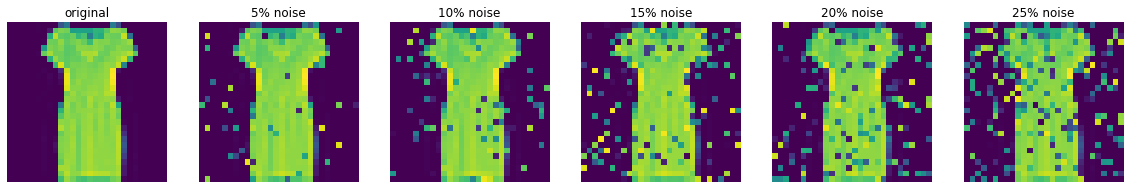

In [ ]:
id = 20
row = 1
column = 6
fig = plt.figure(figsize=(20, 20))

fig.add_subplot(row,column,1)
plt.imshow(x_train[id].reshape(28,28))
plt.axis('off')
plt.title("original")

fig.add_subplot(row,column,2)
plt.imshow(noise5[id].reshape(28,28))
plt.axis('off')
plt.title("5% noise")

fig.add_subplot(row,column,3)
plt.imshow(noise10[id].reshape(28,28))
plt.axis('off')
plt.title("10% noise")

fig.add_subplot(row,column,4)
plt.imshow(noise15[id].reshape(28,28))
plt.axis('off')
plt.title("15% noise")

fig.add_subplot(row,column,5)
plt.imshow(noise20[id].reshape(28,28))
plt.axis('off')
plt.title("20% noise")

fig.add_subplot(row,column,6)
plt.imshow(noise25[id].reshape(28,28))
plt.axis('off')
plt.title("25% noise")

# Design Network


In [ ]:
#implement Layer class to deal with input, output, fp,bp
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

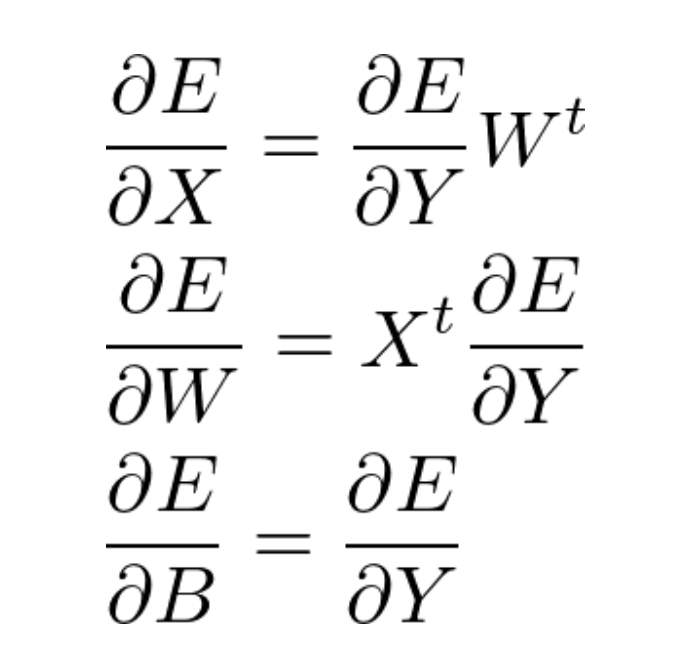

In [ ]:
# implement Fully connected Layer
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [ ]:
#implement Activation inherit from Layer class
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [ ]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

In [ ]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

In [ ]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data, correct_ans):
        # sample dimension first
        samples = len(input_data)
        result = []
        err = 0
        acc = 0
        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            err += self.loss(correct_ans[i], output)
            acc += np.sum(np.argmax(correct_ans[i]) == np.argmax(output))
            result.append(output)
        err /= samples
        acc /= samples
        return result, err, acc
    

    # train the network
    def fit(self, x_train, y_train, x_test, y_test, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)
        test_samples = len(x_test)
        train_loss = []
        train_acc = []
        test_loss = []
        test_acc = []
        # training loop
        for i in range(epochs):
            err = 0
            acc = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)
                acc += np.sum(np.argmax(y_train[j]) == np.argmax(output)) 
                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average training loss and accuracy on all samples
            err /= samples
            acc /= samples
            train_loss.append(err)
            train_acc.append(acc)
            #print('epoch %d/%d   error=%f  accurary=%f' % (i+1, epochs, err, acc))

            #calculate test loss and accuracy on all samples
            _, test_loss_tmp, test_acc_tmp = self.predict(x_test,y_test)
            test_loss.append(test_loss_tmp)
            test_acc.append(test_acc_tmp)
            
        return (train_loss, test_loss, train_acc, test_acc)
       
            #check hidden layer
    def see_hidden_layer(self, input_data,correct_ans):
        samples = len(input_data)
        result = []
        total_cols = 10
        flag=0
        fig, ax = plt.subplots(nrows=2, ncols=total_cols,
                      figsize=(18,4),
                      subplot_kw=dict(xticks=[], yticks=[]))  
        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
                if flag ==0:
                  flag=1
                  hidden = output
            shape = int(np.sqrt(len(hidden[0])))
            ax[0, i].imshow(input_data[i][0].reshape(28,28))
            ax[1, i].imshow(hidden.reshape(shape,shape))   
            ax[0, i].set_title('Digit ' + str(np.argmax(correct_ans[i])))
            ax[1, i].set_title('Classification ' + str(np.argmax(output)))
            result.append(output)
            flag = 0
        return result

In [ ]:
net = Network()
net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

#Evaluate and Compare Model with Various Amount of Noise

In [ ]:
#plot train and test loss and validation
def plot( history,epochs = 35):
  epochs = 35
  (train_loss, test_loss, train_acc, test_acc)=history
  print('train loss = %f,   validation loss = %f,  train accurary = %f, validation accuracy = %f' % (train_loss[-1], test_loss[-1], train_acc[-1], test_acc[-1]))
  figure, axis = plt.subplots(1, 2,figsize=(16, 8))
  axis[0].plot(range(1,epochs+1), train_acc, 'g', label='Train Accuracy')
  axis[0].plot(range(1,epochs+1), test_acc, 'b', label='Validation Accuracy')
  axis[0].set_title('Accuracy Graph')
  axis[0].set_xlabel('Epochs')
  axis[0].set_ylabel('Accuracy(%)')
  axis[0].legend()

  axis[1].plot(range(1,epochs+1), train_loss, 'g', label='Train Loss')
  axis[1].plot(range(1,epochs+1), test_loss, 'b', label='Validation Loss')
  axis[1].set_title('loss Graph')
  axis[1].set_xlabel('Epochs')
  axis[1].set_ylabel('Loss(%)')
  axis[1].legend()
  plt.show()

==No Noise==
train loss = 0.021421,   validation loss = 0.032880,  train accurary = 0.916833, validation accuracy = 0.822000


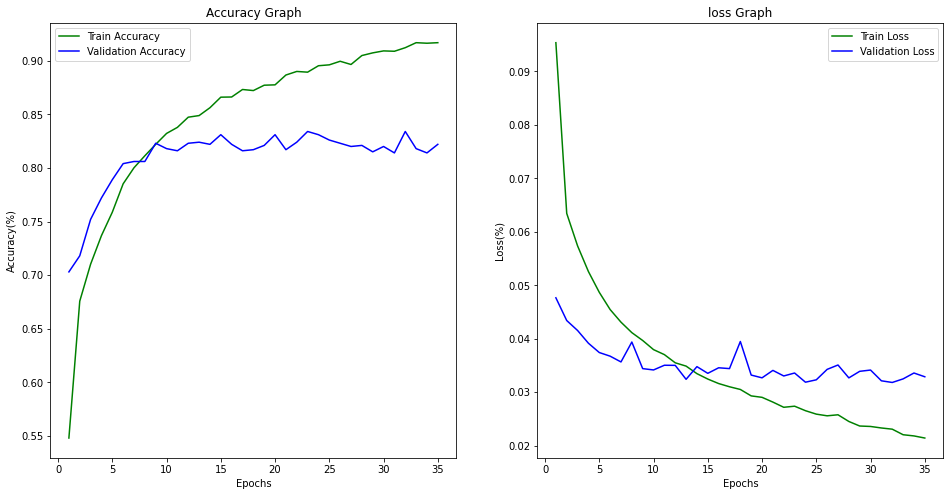

==Noise 5%==
train loss = 0.012903,   validation loss = 0.031376,  train accurary = 0.954833, validation accuracy = 0.833000


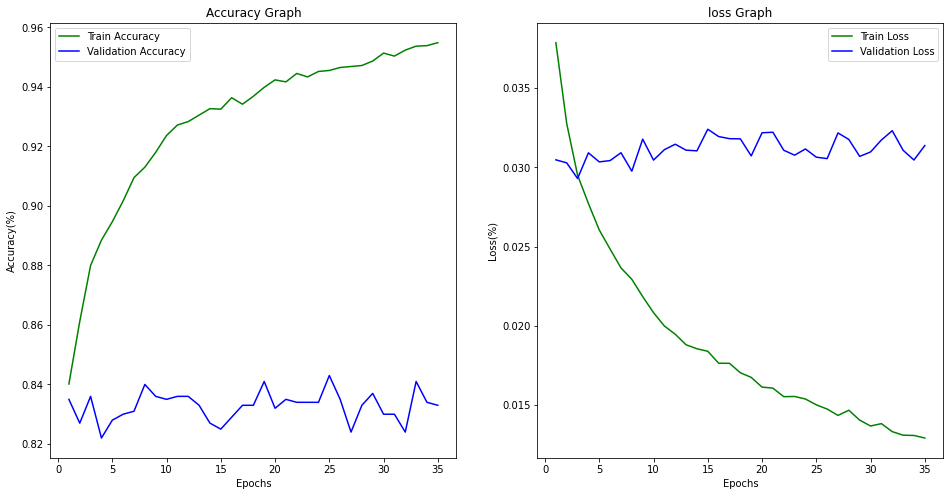

==Noise 10%==
train loss = 0.011791,   validation loss = 0.032294,  train accurary = 0.957500, validation accuracy = 0.833000


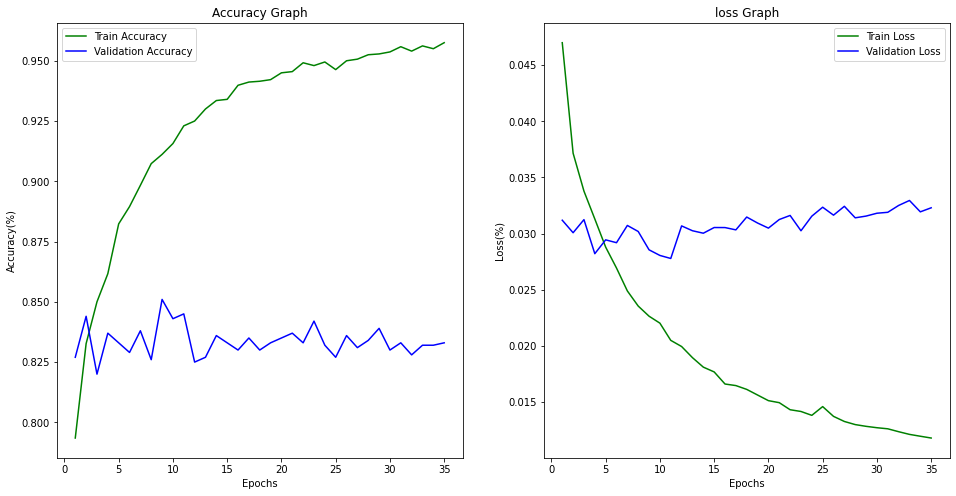

==Noise 15%==
train loss = 0.011858,   validation loss = 0.032420,  train accurary = 0.953500, validation accuracy = 0.827000


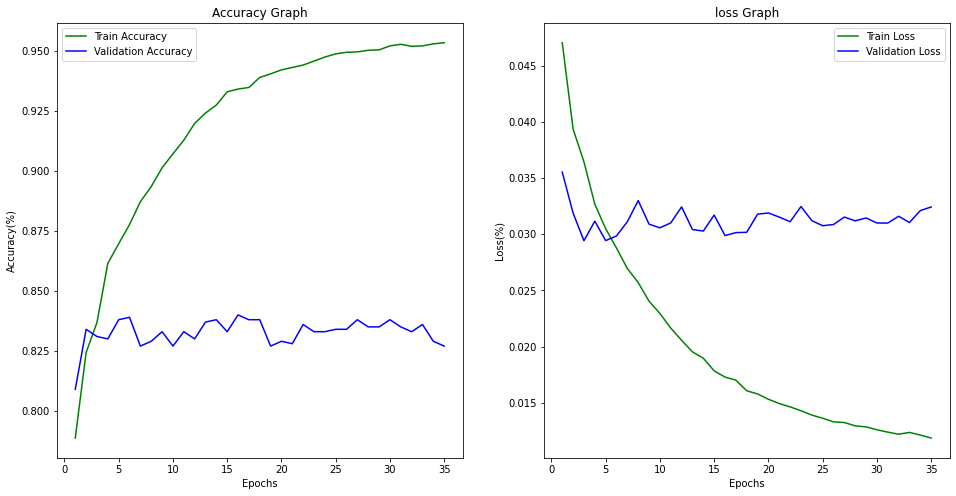

==Noise 20%==
train loss = 0.012808,   validation loss = 0.032077,  train accurary = 0.949833, validation accuracy = 0.832000


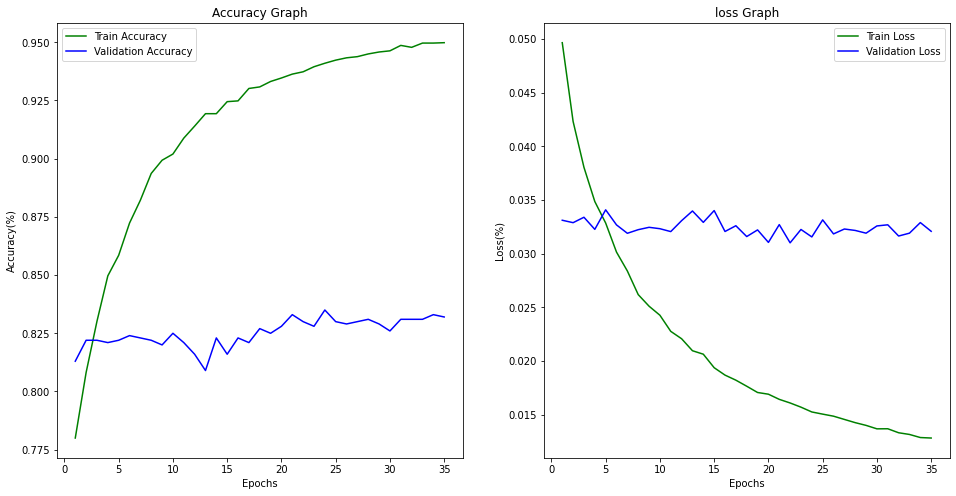

==Noise 25%==
train loss = 0.014172,   validation loss = 0.033577,  train accurary = 0.942833, validation accuracy = 0.823000


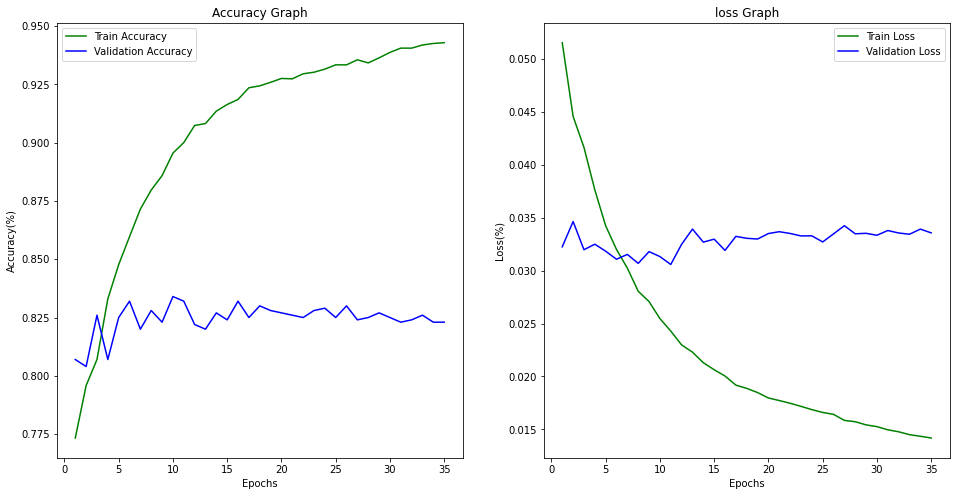

In [ ]:
# train on 1000 samples
net.use(mse, mse_prime)
print("==No Noise==")
history = net.fit(x_train, y_train, x_test, y_test, epochs=35, learning_rate=0.1)
plot(history)

print("==Noise 5%==")
history1= net.fit(noise5, y_train, x_test, y_test, epochs=35, learning_rate=0.1)
plot(history1)

print("==Noise 10%==")
history2= net.fit(noise10, y_train, x_test, y_test, epochs=35, learning_rate=0.1)
plot(history2)

print("==Noise 15%==")
history3= net.fit(noise15, y_train, x_test, y_test, epochs=35, learning_rate=0.1)
plot(history3)

print("==Noise 20%==")
history4= net.fit(noise20, y_train, x_test, y_test, epochs=35, learning_rate=0.1)
plot(history4)

print("==Noise 25%==")
history5= net.fit(noise25, y_train, x_test, y_test, epochs=35, learning_rate=0.1)
plot(history5)



#Check Hidden Layer Output

[array([[-1.10235104e-03,  1.88576795e-03, -1.63490627e-02,
         -2.05785000e-02, -5.01423431e-03,  3.22007318e-03,
         -1.86825430e-03, -3.42686913e-04,  4.55662255e-02,
          9.78826621e-01]]),
 array([[-8.64640814e-03,  5.37433428e-03,  9.35628773e-01,
         -3.26525377e-02, -1.07529251e-02,  8.95977432e-06,
         -3.89199391e-02,  4.03385267e-03,  9.67863654e-02,
          2.16689721e-03]]),
 array([[ 0.00418348,  0.96236425, -0.04555636, -0.01612307,  0.02548781,
         -0.0013167 ,  0.02998734,  0.00151112,  0.06441554,  0.0013308 ]]),
 array([[ 3.85486902e-03,  9.59793736e-01, -4.54404346e-02,
         -1.11996499e-02,  2.38245387e-02, -2.31815391e-03,
          3.55136344e-02,  1.23827242e-03,  7.06391651e-02,
          4.82289678e-05]]),
 array([[ 6.72359236e-03,  7.63170141e-03,  6.33247993e-03,
         -4.76842474e-02, -1.25772401e-02,  2.45827693e-05,
          9.65730442e-01,  1.60147479e-03,  6.73060613e-02,
         -6.85196743e-05]]),
 array([[ 4.7

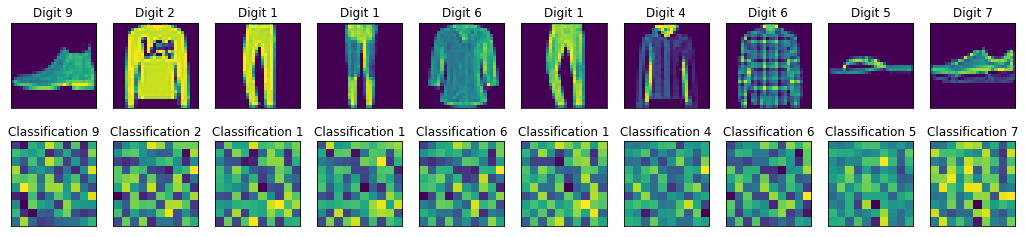

In [ ]:
#check hidden layer
net.use(mse, mse_prime)
history=net.fit(x_train, y_train, x_test, y_test, epochs=35, learning_rate=0.1)
net.see_hidden_layer(x_test[0:10],y_test[0:10])

#Try 5 layer Deep Neural Network with more neurons

In [ ]:
#try deeper neural network with 5 layesr
deepnet = Network()
deepnet.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
deepnet.add(ActivationLayer(tanh, tanh_prime))
deepnet.add(FCLayer(100, 80))                   # input_shape=(1, 100)      ;   output_shape=(1, 80)
deepnet.add(ActivationLayer(tanh, tanh_prime))
deepnet.add(FCLayer(80, 50))                    # input_shape=(1, 80)       ;   output_shape=(1, 10)
deepnet.add(ActivationLayer(tanh, tanh_prime))
deepnet.add(FCLayer(50, 30))                    # input_shape=(1, 50)       ;   output_shape=(1, 30)
deepnet.add(ActivationLayer(tanh, tanh_prime))
deepnet.add(FCLayer(30, 10))                    # input_shape=(1, 30)       ;   output_shape=(1, 10)
deepnet.add(ActivationLayer(tanh, tanh_prime))

==No Noise==
train loss = 0.015491,   validation loss = 0.027393,  train accurary = 0.919833, validation accuracy = 0.833000


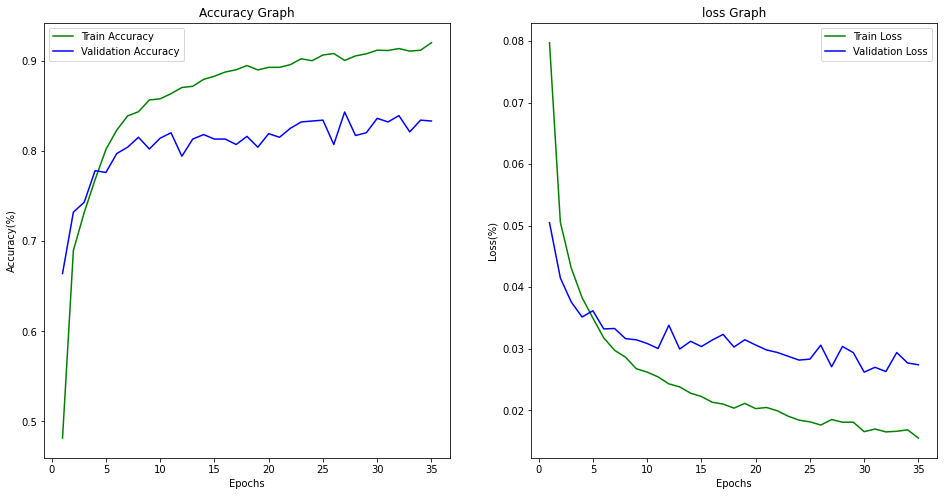

In [ ]:
deepnet.use(mse, mse_prime)
print("==No Noise==")
history = deepnet.fit(x_train, y_train, x_test, y_test, epochs=35, learning_rate=0.1)
plot(history)